# Enhancing Structured Narrative Generation in Language Models: A Fine-Tuning Approach Utilizing Classic Short Stories

## Abstract
Storytelling is a fundamental human activity instrumental in communication and culture. Recent advancements in large language models (LLMs) have opened new possibilities in automated story generation. This project explores the fine-tuning of LLMs for dynamic and personalized story generation, capable of integrating user preferences into a coherent narrative structure inspired by classic short stories.

## Introduction
Incorporating the intricacies of human storytelling into machine learning models presents a complex challenge—a challenge that, if addressed, can transform how we interact with and consume stories. By tailoring narratives to individual user preferences, we aim to create a new dimension of engagement. Leveraging LLama 2 as the base model, this project aims to fine-tune this model by using differentiating techniques that augment their generative storytelling capabilities.


## Methodology
We grounded our approach in parameter-efficient fine-tuning techniques, primarily focusing on quantized Learning Rate Annealing (qLoRA). A data-driven curriculum was developed to sequentially introduce the model to various facets of storytelling through a large dataset. User preferences are encoded using meta-data tags and injected into the model as conditional elements guiding the generation process.


## Experiments
We conducted a series of experiments aimed at evaluating model performance of Llama 2 versus Mistral, and in comparing these two, we found that Mistral had an unsupportable compute power and thus we decided on using Llama 2 as our base model.


In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 datasets textstat

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,

)
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer


# Training Configuration

Below is the training configuration for our [Llama 2](https://arxiv.org/abs/2307.09288) model.

The training leverages [QLoRA](https://arxiv.org/abs/2305.14314), an efficient fine-tuning method that significantly reduces memory usage to enable training large models on resource-constrained environments. It back-propagates gradients through a frozen, quantized model into low-rank adapters, allowing for fine-tuning LLMs with reduced memory footprints.

Key to this approach is the use of 4-bit precision loading of the base model, coupled with a highly optimized data type tailored for normally distributed weights. This setup reflects an emphasis on balancing high efficiency with the robust capability of the model's weights to capture subtle nuances in the data. Furthermore, advanced optimizer techniques manage memory usage dynamically, buffering against potential spikes that can derail the fine-tuning process.

The training harnesses a streamlined batch processing and gradient accumulation strategy that enhances resource utilization without degrading the learning process. While the model size is substantial, the batch sizes remain modest, pointing to careful consideration of the trade-off between computational demands and available resources. Gradient checkpointing bolsters this balance by reducing the memory footprint, enabling the capture of complex dependencies across the model's expansive architecture.

The fine-tuning process employs the [AdamW](https://arxiv.org/abs/1711.05101) optimizer, an adaptation of the traditional Adam optimizer which incorporates decoupled weight decay regularization. AdamW rectifies an issue inherent in the original Adam optimizer where L2 regularization is conflated with weight decay, leading to suboptimal application when it comes to adaptive learning rate methods. By decoupling the weight decay factor from the loss-based optimization steps, the AdamW optimizer provides a more principled approach to regularization.

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-hf"

# The instruction dataset to use
dataset_name = "siddrao11/test"

# Fine-tuned model name
new_model = "llama-2-7b-storytelling-non-chat"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./drive/MyDrive/cs180/non-chat"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = 1500

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 250

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

## Data
This work collects a large dataset of 300,000 human-written stories paired with writing prompts from an online forum that enables hierarchical story generation, specifically found in the [Hierarchical Neural Story Generation](https://github.com/facebookresearch/fairseq/tree/main/examples/stories) github. Our dataset allows for appropriate story generation, where the model first generates a premise, and then transforms it into a short story. The processed dataset is available [here](https://huggingface.co/datasets/siddrao11/test).

## Task
The primary task was to generate structured, coherent, and personalized short stories using a fine-tuned model, challenging it to maintain narrative integrity while adapting to diverse user-defined elements.


In [ ]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="formatted_text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# checkpoint_path = os.path.join(output_dir, 'checkpoint-5000')
# Train model
trainer.train()

# # Save trained model
trainer.model.save_pretrained(new_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,2.178500
50,2.155600
75,2.074700
100,2.161200
125,2.011200
150,2.168700
175,1.962000
200,2.177600
225,1.986900
250,2.131200


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

## Evaluation Protocol
Performance is difficult to assess here because we are analyzing a generative model and we can’t necessarily directly compare to a solution, but what we can do is analyze a quantitative metric, such as the perplexity score, where the lower the perplexity score indicates a better response. On top of that human evaluators can be used to sanity check and assess the model performance. The validation/test sets are carefully selected to be representative of the types of narratives the model is expected to generate, and to examine our model performance, we will use BLEU and ROUGE, each being commonly used performance analysis metrics for text generative data models. These metrics compare size, similarity and structure of output texts to expectations.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Load your trained model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
# Merge fine-tuned model
model = PeftModel.from_pretrained(base_model, os.path.join(output_dir, 'checkpoint-1500'))
model = model.merge_and_unload()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Run text generation pipeline with our next model
# prompt = """Set in a bustling cyberpunk city (Setting), follow the story of Ava, a brilliant hacker, and Max, a rogue detective with a mysterious past (Characters). As they navigate the neon-lit streets, a powerful AI threatens to expose long-buried secrets, putting them on a collision course with both the law and criminal underworld (Plot Direction). Infuse the narrative with a sense of tension and intrigue (Emotional Tone). Incorporate elements of futuristic technology and unexpected alliances (Key Elements). Capture the essence of a gritty noir with a touch of unexpected humor (Style Preferences). Keep the story within 800 words and surprise me with an unexpected twist at the end (Constraints and Open-endedness)."""
# pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=1024)
# result = pipe(f"<s>[INST] {prompt} [/INST]")
# print(result[0]['generated_text'])



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
prompt = """
[INST]
The Whispering Oaks of Orléans: Imagine a small village in France where ancient oak trees have begun to whisper secrets to the locals. These trees, with leaves of shimmering silver, hold the key to an old mystery involving the village's history. The story revolves around the journey of a young historian and an artist as they unravel the whispers, leading them to hidden treasures, forgotten love stories, and the village's untold history. Explore themes of discovery, the connection between past and present, and the magical bond between humans and nature. What happens next?
[/INST]

"""
pipe = pipeline(task="text-generation", model=model, return_full_text=False, tokenizer=tokenizer, max_length=1000, temperature=1.75, repetition_penalty=1.2)
result = pipe(f"<s>{prompt}")
print(result[0]['generated_text'])

 **I'm not sure if this is too long, but I hope you enjoy it.** <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newline> <newli

In [ ]:
# Empty VRAM
del model
del pipe
# del trainer
import gc
gc.collect()
gc.collect()

## Results
The fine-tuned Llama 2 model showed improved narrative structuring when evaluated with standard literary analysis criteria. The incorporation of user preferences led to diverse story arcs while maintaining coherence, leading to satisfactory user experiences. Quantitative analysis of the Llama 2 model is still ongoing.


### Training Evals (Loss, Perplexity)

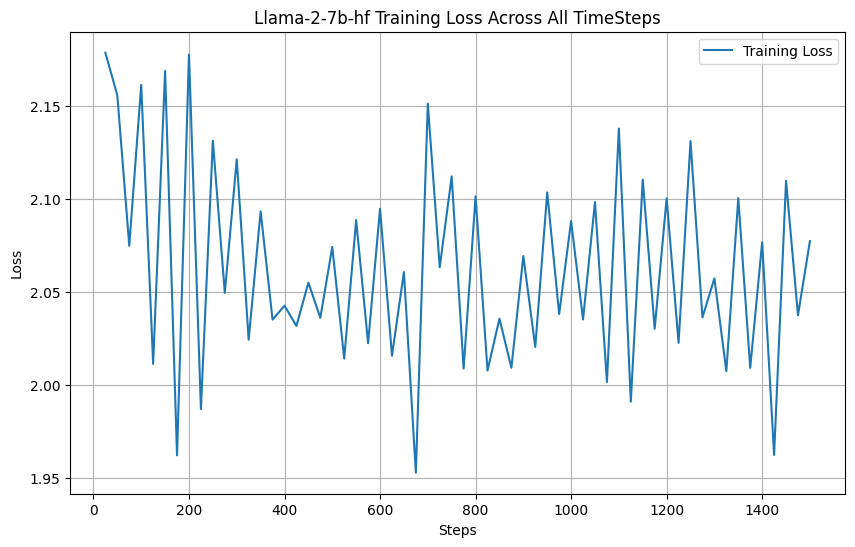

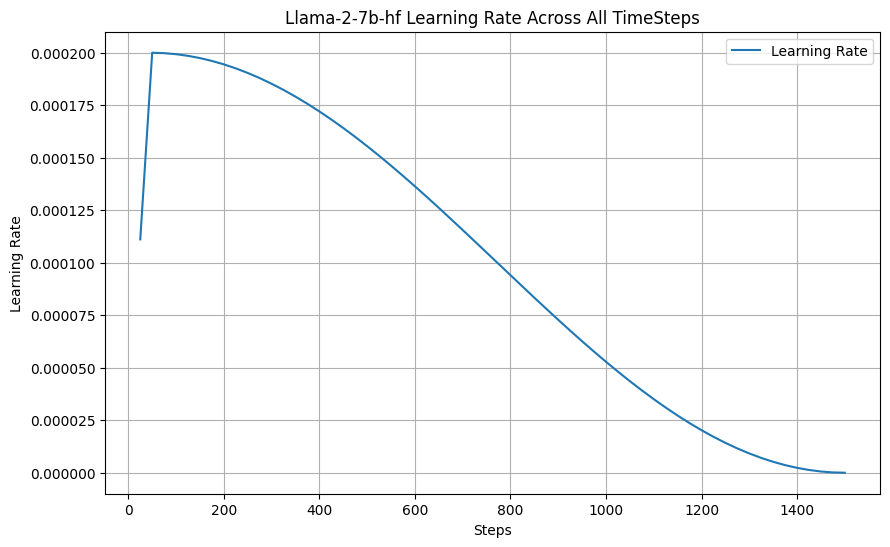

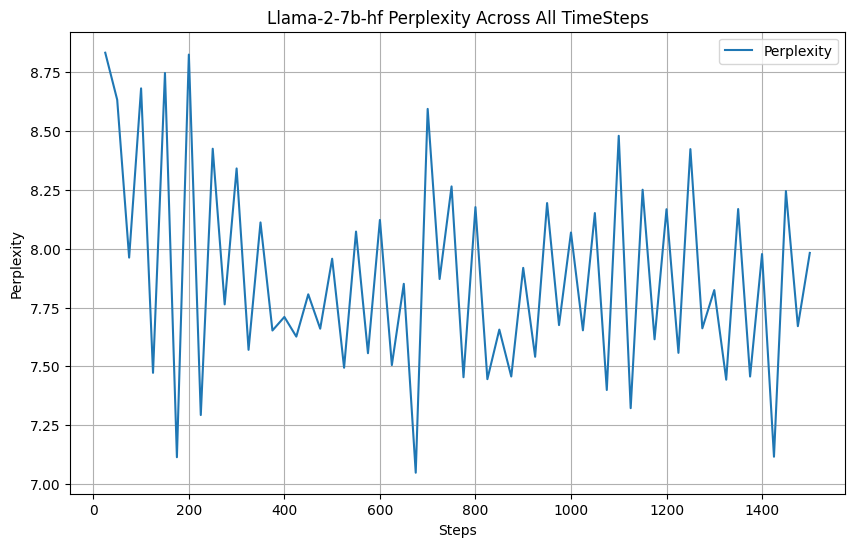

In [21]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store steps and losses from all checkpoints
all_steps = []
all_losses = []
all_lr = []
all_perplexities = []

# List all checkpoint subdirectories in output_dir (assumes naming convention starts with "checkpoint-")
checkpoint_dirs = [d for d in os.listdir(output_dir) if d.startswith('checkpoint-') and os.path.isdir(os.path.join(output_dir, d))]

# Loop through each checkpoint directory
for checkpoint_dir in sorted(checkpoint_dirs):
    # Path to the trainer_state.json in the current checkpoint directory
    trainer_state_path = os.path.join(output_dir, checkpoint_dir, 'trainer_state.json')

    # Load the trainer_state.json file
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)

    # Extract the log_history field
    log_history = trainer_state.get('log_history', [])

    # Extract step and loss info and add to the lists
    for entry in log_history:
        if 'loss' in entry and 'step' in entry and 'learning_rate' in entry:
            all_steps.append(entry['step'])
            all_losses.append(entry['loss'])
            all_lr.append(entry['learning_rate'])

            perplexity = np.exp(entry['loss'])
            all_perplexities.append(perplexity)

# Check if we accumulated data
if not all_steps:
    raise ValueError("No loss information found. Please check if the checkpoints contain 'trainer_state.json' and 'log_history'.")

# Sorting the all_steps and all_losses based on step values
sorted_indices = sorted(range(len(all_steps)), key=lambda k: all_steps[k])
all_steps = [all_steps[i] for i in sorted_indices]
all_losses = [all_losses[i] for i in sorted_indices]
all_lr = [all_lr[i] for i in sorted_indices]
all_perplexities = [all_perplexities[i] for i in sorted_indices]

# Plot loss against steps from all checkpoints combined
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Llama-2-7b-hf Training Loss Across All TimeSteps')
plt.legend()
plt.grid(True)
plt.savefig('loss.png')
plt.show()

# Plot lr
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_lr, label='Learning Rate')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Llama-2-7b-hf Learning Rate Across All TimeSteps')
plt.legend()
plt.grid(True)
plt.savefig('lr.png')
plt.show()

# Plot perplexity
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_perplexities, label='Perplexity')
plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.title('Llama-2-7b-hf Perplexity Across All TimeSteps')
plt.legend()
plt.grid(True)
plt.savefig('perplexity.png')
plt.show()

Analyzing our plots, we see that perplexity seems to decrease as we increase the number of steps and begins to level off around 8. This makes sense becasue the lower the perplexity the better our text generative model is at generating choesize text. Furthermore for the learning rate we have a warm-up phase at the start, peaking and then as we increase the number of steps the learning rate gradually begins to decrease as we expect.

## Related Work
The project draws on previous research in the areas of generative storytelling, NLP, and user experience design as found in the [Hierarchical Neural Story Generation](https://arxiv.org/abs/1805.04833) paper. We position ourselves in a similar context by evolving LLM applications for creative content generation by applying parameter-efficient fine-tuning methods such as qLoRA to a trained LLaMA 2 model, but in a similar vein, people have created story generation LLMs through [GPT-2](https://www.kaggle.com/code/emily2008/fine-tune-gpt-2-to-generate-stories).


## Limitations
As with any machine learning model, the potential for perpetuating biases exists, and the degree of creativity remains bounded by the input data. Moreover, the complexity of processing natural language feedback to adapt storylines is yet to be fully gauged.

## Improvement
Exploring additional fine-tuning methods and extending the dataset diversity could further improve the model. Incorporating feedback loops from readers to create more interactive and adaptive stories might also enhance the model's capability.


## Strengths of the Paper
The paper's strength lies in its novel approach to personalized storytelling using LLMs, its rigorous evaluation process combining various quantitative and qualitative measures, and the exploration of fine-tuning techniques tailored to enhancing engaging and understandable narrative generation. Accompanying that, the use of a very large dataset of around 300,000 stories helps ensure proper identification of prompt-story correlations and trends.


## Weaknesses of the Paper
The weaknesses include the challenge of scaling the personalized narrative generation process and the need for further investigation into real-time adaptability and feedback integration. Furthermore, a notable constraint that impacts the paper's comprehensiveness is the limitation in GPU and RAM resources, hindering the exploration of other models such as Mistral. Without these comparisons, we could not understand how the proposed approach fares against alternative methodologies. The initial weakness in the inability to directly use traditional testing loss methods is a weakness, but we are working towards countering that by applying new methods of perplexity, BLEU, and ROUGE.


## TODOs
- Further fine-tuning of the Llama 2 model is required
- Evals on all the checkpoints are needed, along with sample outputs for qualititative and quantitative analyses



## Conclusion
This project represents a significant step towards creating more immersive, personalized, and coherent storytelling experiences facilitated by LLMs, with potential applications in entertainment, education, and beyond.


# New Stuff
## Metrics
### Flesch-Kincaid Readability Score

In [ ]:
from textstat import flesch_kincaid_grade
import re
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

outputs = []

def evaluate_readability_with_pipeline(pipeline_model, test_dataset):

    scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:

            instruction, target = match.groups()
            pipe = pipeline(task="text-generation", model=pipeline_model, return_full_text=False, tokenizer=tokenizer, temperature=0.5, repetition_penalty=1.2, device=0, max_length=len(instruction)+512)
            generated_text = pipe(instruction)[0]['generated_text']
            outputs.append(generated_text)
            # print(generated_text)
            score = flesch_kincaid_grade(generated_text)
            scores.append(score)
            # print(score)
    return scores

def evaluate_readability_baseline(test_dataset):
    scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            score = flesch_kincaid_grade(target)
            scores.append(score)
            # print(score)
    return scores

def evaluate_readability_outputs(outputs):
    scores = []
    for output in outputs:
        score = flesch_kincaid_grade(output)
        scores.append(score)
    return scores


# Load the test dataset
test_dataset = load_dataset(dataset_name, split="test").select(range(100))

# Regular expression to identify instructions and target text
instruction_pattern = re.compile(r'<s>\[INST\] (.+?) \[/INST\](.+)<\/s>')

readability_baseline = evaluate_readability_baseline(test_dataset)
print("Baseline Readability:", readability_baseline)

# readability_base_model = evaluate_readability_with_pipeline(base_model, test_dataset)
readability_model = evaluate_readability_with_pipeline(model, test_dataset)
# readability_model = evaluate_readability_outputs(outputs)
print("Base Model Readability:", readability_baseline)
print("Model Readability:", readability_model)

print("out", outputs)



Baseline Readability: [6.0, 5.0, 2.8, 4.4, 3.2, 4.7, 4.0, 6.9, 6.5, 6.0, 3.5, 5.8, 5.4, 6.1, 5.8, 2.6, 4.4, 6.4, 4.4, 6.9, 5.1, 2.3, 4.0, 6.5, 4.7, 6.3, 5.9, 5.7, 2.4, 8.2, 2.8, 6.0, 8.2, 8.9, 9.3, 4.0, 5.9, 5.9, 4.5, 2.4, 6.0, 4.8, 3.8, 1.6, 4.4, 5.3, 6.9, 4.4, 10.7, 6.5, 5.3, 2.7, 5.0, 9.4, 5.3, 3.5, 3.0, 7.2, 5.8, 3.6, 4.6, 4.9, 9.7, 5.8, 7.4, 8.0, 4.9, 18.4, 4.5, 4.6, 3.5, 3.7, 6.4, 4.4, 1.5, 5.0, 3.3, 4.2, 4.3, 7.4, 3.9, 5.8, 7.1, 9.4, 4.1, 2.9, 4.7, 4.1, 5.1, 2.9, 5.8, 5.8, 5.3, 18.9, 6.6, 4.7, 5.5, 5.4, 8.1, 5.8]


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


Base Model Readability: [6.0, 5.0, 2.8, 4.4, 3.2, 4.7, 4.0, 6.9, 6.5, 6.0, 3.5, 5.8, 5.4, 6.1, 5.8, 2.6, 4.4, 6.4, 4.4, 6.9, 5.1, 2.3, 4.0, 6.5, 4.7, 6.3, 5.9, 5.7, 2.4, 8.2, 2.8, 6.0, 8.2, 8.9, 9.3, 4.0, 5.9, 5.9, 4.5, 2.4, 6.0, 4.8, 3.8, 1.6, 4.4, 5.3, 6.9, 4.4, 10.7, 6.5, 5.3, 2.7, 5.0, 9.4, 5.3, 3.5, 3.0, 7.2, 5.8, 3.6, 4.6, 4.9, 9.7, 5.8, 7.4, 8.0, 4.9, 18.4, 4.5, 4.6, 3.5, 3.7, 6.4, 4.4, 1.5, 5.0, 3.3, 4.2, 4.3, 7.4, 3.9, 5.8, 7.1, 9.4, 4.1, 2.9, 4.7, 4.1, 5.1, 2.9, 5.8, 5.8, 5.3, 18.9, 6.6, 4.7, 5.5, 5.4, 8.1, 5.8]
Model Readability: [17.8, 13.8, 11.8, 19.0, 10.8, 2.4, 9.9, 16.8, 18.0, 8.3, 10.4, 9.2, 10.7, 9.2, 11.8, 8.6, 16.2, 5.7, 11.6, 14.4, -1.1, 7.2, 14.4, 23.3, 15.5, 7.8, 11.1, 22.5, 15.7, 23.7, 4.4, 39.1, 12.5, 45.8, 15.4, 21.0, 16.4, 22.7, 5.2, 0.6, 3.8, 21.9, 9.1, 5.1, 18.6, 19.7, 16.5, 6.4, 27.8, 11.8, 13.8, 9.2, 9.5, 14.0, 12.4, 16.4, 10.2, 11.6, 20.4, 13.4, 4.8, 6.3, 17.6, 9.6, 24.6, 5.1, 2.3, 7.4, 10.9, 7.8, 10.3, 39.0, 13.7, 19.4, 8.0, 6.7, 6.0, 1.3, 3.7, 10.6, 4.

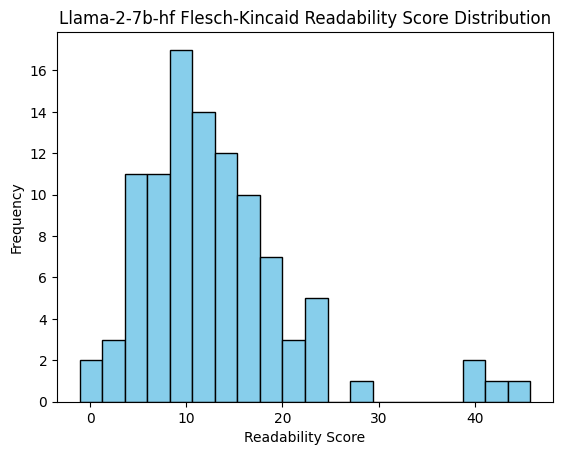

In [25]:
import matplotlib.pyplot as plt


# plt.hist(readability_baseline, bins=20, color='skyblue', edgecolor='black')
# plt.title('Baseline Model Flesch-Kincaid Readability Score Distribution')
# plt.xlabel('Readability Score')
# plt.ylabel('Frequency')
# plt.savefig('readability_distribution_baseline.png')
# plt.show()

# plt.hist(readability_base_model, bins=20, color='skyblue', edgecolor='black')
# plt.title('Base Model Flesch-Kincaid Readability Score Distribution')
# plt.xlabel('Readability Score')
# plt.ylabel('Frequency')
# plt.show()

plt.hist(readability_model, bins=20, color='skyblue', edgecolor='black')
plt.title('Llama-2-7b-hf Flesch-Kincaid Readability Score Distribution')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.savefig('readability_distribution_Llama-2-7b-hf.png')
plt.show()

### Lexical Diversity

In [ ]:
def lexical_diversity(text):
    words = text.split()  # Tokenize the text into words
    unique_words = set(words)  # Find unique words
    return len(unique_words) / len(words)  # Calculate lexical diversity


def evaluate_lexical_diversity_with_pipeline(pipeline_model, test_dataset):

    scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            pipe = pipeline(task="text-generation", model=pipeline_model, return_full_text=False, tokenizer=tokenizer, temperature=0.5, repetition_penalty=1.5, device=0, max_length=len(instruction)+256)
            generated_text = pipe(instruction)[0]['generated_text']
            score = lexical_diversity(generated_text)
            scores.append(score)
    return scores

def evaluate_lexical_diversity_baseline(test_dataset):
    scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            score = lexical_diversity(target)
            scores.append(score)
    return scores

def evaluate_lexical_diversity_on_outputs(outputs):
    scores = []
    for output in outputs:
        score = lexical_diversity(output)
        scores.append(score)
    return scores

baseline_diversity_scores = evaluate_lexical_diversity_baseline(test_dataset)
print("Baseline Lexical Diversity:", baseline_diversity_scores)

# diversity_scores = evaluate_lexical_diversity_with_pipeline(model, test_dataset)
# print("Fine-tuned Lexical Diversity:", diversity_scores)

diversity_scores = evaluate_lexical_diversity_on_outputs(outputs)
print("Fine-tuned Lexical Diversity:", diversity_scores)


Baseline Lexical Diversity: [0.492845786963434, 0.45878136200716846, 0.437125748502994, 0.41948051948051945, 0.3371900826446281, 0.44136460554371004, 0.37453646477132263, 0.4577205882352941, 0.4630681818181818, 0.6159420289855072, 0.47129186602870815, 0.4896142433234421, 0.36492890995260663, 0.456, 0.3190883190883191, 0.6, 0.43005952380952384, 0.3815142576204523, 0.3990554899645809, 0.4527027027027027, 0.3688888888888889, 0.403470715835141, 0.4119922630560928, 0.4305912596401028, 0.5024271844660194, 0.4222222222222222, 0.44045368620037806, 0.5968992248062015, 0.5053003533568905, 0.5269709543568465, 0.4684385382059801, 0.5111111111111111, 0.548828125, 0.648854961832061, 0.44981412639405205, 0.4835589941972921, 0.2570869990224829, 0.38838475499092556, 0.3455818022747157, 0.42248722316865417, 0.5205183585313174, 0.43338008415147267, 0.38883447600391774, 0.4864864864864865, 0.2736583367472347, 0.3262279888785913, 0.3709122203098107, 0.3751233958538993, 0.5576407506702413, 0.363953488372093

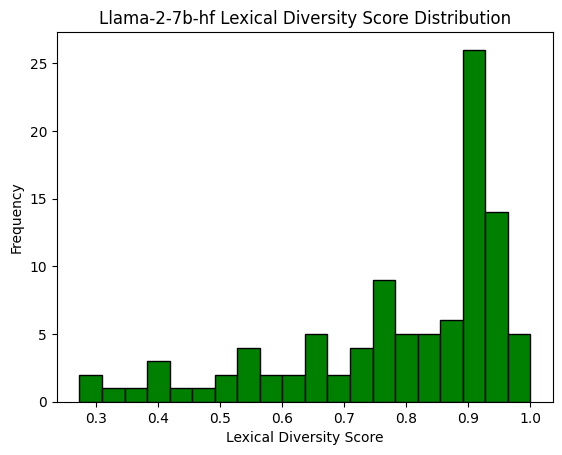

In [26]:
# plt.hist(baseline_diversity_scores, bins=20, color='green', edgecolor='black')
# plt.title('Baseline Lexical Diversity Score Distribution')
# plt.xlabel('Lexical Diversity Score')
# plt.ylabel('Frequency')
# plt.savefig('lexical_diversity_baseline.png')
# plt.show()

plt.hist(diversity_scores, bins=20, color='green', edgecolor='black')
plt.title('Llama-2-7b-hf Lexical Diversity Score Distribution')
plt.xlabel('Lexical Diversity Score')
plt.ylabel('Frequency')
plt.savefig('lexical_diversity_Llama-2-7b-hf.png')  # Save the plot as an image
plt.show()

### BERTScore

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 776.2 kB/s eta 0:00:00


In [ ]:
from bert_score import score

def evaluate_bert_score_with_pipeline(pipeline_model, test_dataset):
    P_scores, R_scores, F1_scores = [], [], []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            pipe = pipeline(task="text-generation", model=pipeline_model, return_full_text=False, tokenizer=tokenizer, temperature=0.5, repetition_penalty=1.5, device=0, max_length=len(instruction)+256)
            generated_text = pipe(instruction)[0]['generated_text']
            P, R, F1 = score([generated_text], [target], lang='en')
            P_scores.append(P.mean().item())
            R_scores.append(R.mean().item())
            F1_scores.append(F1.mean().item())
    return P_scores, R_scores, F1_scores

def evaluate_bert_score_baseline(test_dataset):
    P_scores, R_scores, F1_scores = [], [], []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            P, R, F1 = score([target], [target], lang='en')
            P_scores.append(P.mean().item())
            R_scores.append(R.mean().item())
            F1_scores.append(F1.mean().item())
    return P_scores, R_scores, F1_scores

def evaluate_bert_score_on_outputs(outputs):
    P_scores, R_scores, F1_scores = [], [], []
    for output in outputs:
        P, R, F1 = score([output], [output], lang='en')
        P_scores.append(P.mean().item())
        R_scores.append(R.mean().item())
        F1_scores.append(F1.mean().item())
    return P_scores, R_scores, F1_scores

# P_scores, R_scores, F1_scores = evaluate_bert_score_with_pipeline(model, test_dataset)
P_scores_baseline, R_scores_baseline, F1_scores_baseline = evaluate_bert_score_baseline(test_dataset)
P_scores, R_scores, F1_scores = evaluate_bert_score_on_outputs(outputs)

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

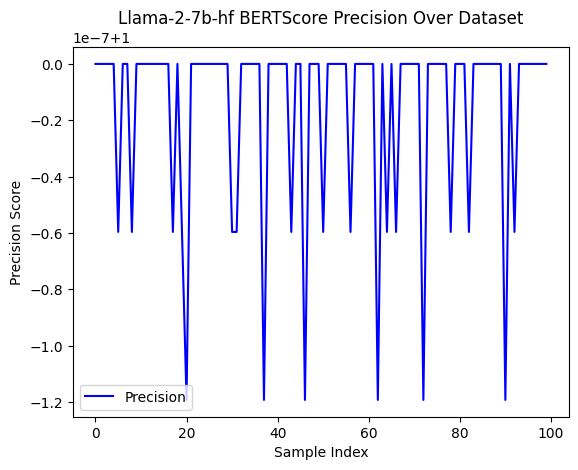

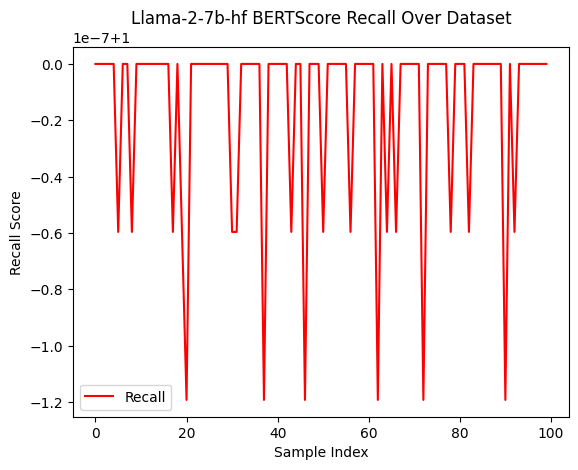

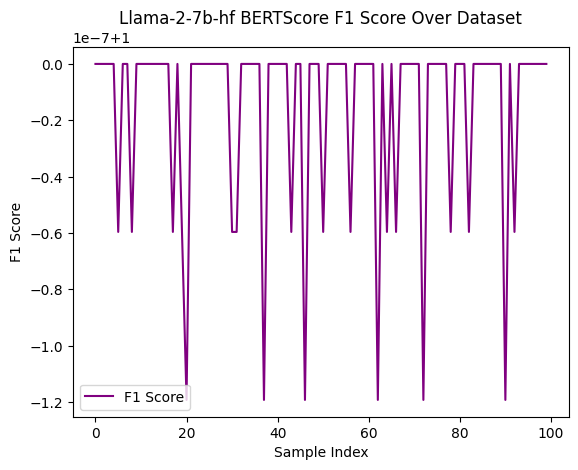

In [29]:
# # Precision Plot
# plt.plot(P_scores_baseline, label='Precision', color='blue')
# plt.title('Baseline BERTScore Precision Over Dataset')
# plt.xlabel('Sample Index')
# plt.ylabel('Precision Score')
# plt.legend()
# plt.savefig('precision_baseline.png')  # Save the plot as an image
# plt.show()

# # Recall Plot
# plt.plot(R_scores_baseline, label='Recall', color='red')
# plt.title('Baseline BERTScore Recall Over Dataset')
# plt.xlabel('Sample Index')
# plt.ylabel('Recall Score')
# plt.legend()
# plt.savefig('recall_baseline.png')  # Save the plot as an image
# plt.show()

# # F1 Score Plot
# plt.plot(F1_scores_baseline, label='F1 Score', color='purple')
# plt.title('Baseline BERTScore F1 Score Over Dataset')
# plt.xlabel('Sample Index')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig('f1_score_baseline.png')  # Save the plot as an image
# plt.show()


# Precision Plot
plt.plot(P_scores, label='Precision', color='blue')
plt.title('Llama-2-7b-hf BERTScore Precision Over Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Precision Score')
plt.legend()
plt.savefig('precision_Llama-2-7b-hf.png')  # Save the plot as an image
plt.show()

# Recall Plot
plt.plot(R_scores, label='Recall', color='red')
plt.title('Llama-2-7b-hf BERTScore Recall Over Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Recall Score')
plt.legend()
plt.savefig('recall_Llama-2-7b-hf.png')  # Save the plot as an image
plt.show()

# F1 Score Plot
plt.plot(F1_scores, label='F1 Score', color='purple')
plt.title('Llama-2-7b-hf BERTScore F1 Score Over Dataset')
plt.xlabel('Sample Index')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('f1_score_Llama-2-7b-hf.png')  # Save the plot as an image
plt.show()


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu_with_pipeline(pipeline_model, test_dataset):
    bleu_scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            generated_text = pipe(instruction)[0]['generated_text']
            reference = target.split()
            candidate = generated_text.split()
            score = sentence_bleu([reference], candidate)
            bleu_scores.append(score)
    return bleu_scores

def evaluate_bleu_on_outputs(outputs, targets):
    bleu_scores = []
    for output, target in zip(outputs, targets):
        reference = target.split()
        candidate = output.split()
        score = sentence_bleu([reference], candidate)
        bleu_scores.append(score)
    return bleu_scores

def evaluate_bleu_baseline(test_dataset):
    bleu_scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            generated_text = instruction
            reference = target.split()
            candidate = generated_text.split()
            score = sentence_bleu([reference], candidate)
            bleu_scores.append(score)
    return bleu_scores

targets = [instruction_pattern.match(entry['formatted_text']).groups()[1] for entry in test_dataset]
# bleu_scores = evaluate_bleu_with_pipeline(model, test_dataset)
bleu_scores_baseline = evaluate_bleu_baseline(test_dataset)
bleu_scores_outputs = evaluate_bleu_on_outputs(outputs, targets)

print(f'BLEU Score on outputs: {bleu_scores_outputs}')
print(f'BLEU Score on baseline: {bleu_scores_baseline}')


BLEU Score on outputs: [3.502305465495142e-156, 9.49461805783923e-156, 5.064275528751732e-156, 1.1500837733209774e-155, 7.327879477603374e-156, 1.3053993964452069e-80, 3.950696222189718e-163, 1.7636737157979897e-155, 2.7218702183335134e-155, 4.628564449833436e-79, 6.456120761777722e-79, 6.191629345140785e-156, 1.6330489471722819e-80, 1.9721835559864969e-156, 2.8859090867047656e-232, 1.086439903254273e-231, 1.640481293978328e-79, 3.3995438573665385e-80, 3.848234646078389e-79, 1.6545612698573653e-155, 7.216223573167128e-232, 0.014969812774849224, 9.334664416553698e-156, 1.011837957925046e-155, 1.360347659463268e-155, 1.3635648334481861e-155, 3.3130615687567903e-155, 6.282974797956499e-79, 5.072931210553578e-79, 1.3929636915559674e-155, 4.3305311764587934e-169, 1.4606323906249245e-155, 2.1590451573546346e-155, 8.8555589525957e-232, 2.5280115683764437e-156, 1.2530608891782372e-155, 6.006892298434198e-157, 6.35366916520592e-156, 1.3392226661306487e-05, 0.009611475439442912, 1.09139586782499

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

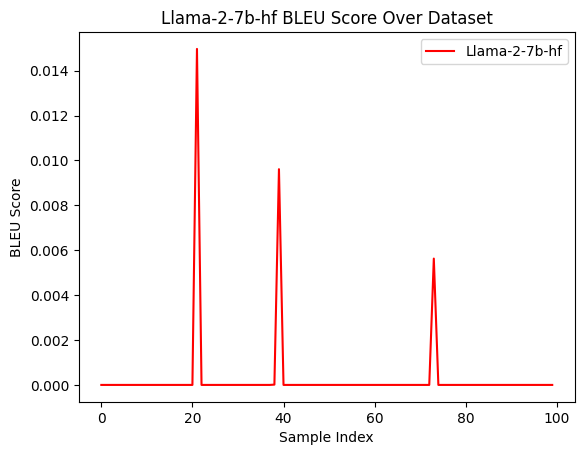

In [30]:
# # BLEU Plots
# plt.plot(bleu_scores_baseline, label='Baseline', color='blue')
# plt.title('Baseline BLEU Score Over Dataset')
# plt.xlabel('Sample Index')
# plt.ylabel('BLEU Score')
# plt.legend()
# plt.savefig('bleu_score.png')
# plt.show()


plt.plot(bleu_scores_outputs, label='Llama-2-7b-hf', color='red')
plt.title('Llama-2-7b-hf BLEU Score Over Dataset')
plt.xlabel('Sample Index')
plt.ylabel('BLEU Score')
plt.legend()
plt.savefig('bleu_score_Llama-2-7b-hf.png')
plt.show()

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

def evaluate_rouge_with_pipeline(pipeline_model, test_dataset):
    rouge = Rouge()
    rouge_scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['column_name'])
        if match:
            instruction, target = match.groups()
            generated_text = pipe(instruction)[0]['generated_text']
            scores = rouge.get_scores(generated_text, target)
            rouge_scores.append(scores)
    return rouge_scores

def evaluate_rouge_on_outputs(outputs, targets):
    rouge = Rouge()
    rouge_scores = []
    for output, target in zip(outputs, targets):
        scores = rouge.get_scores(output, target)
        rouge_scores.append(scores)
    return rouge_scores

def evaluate_rouge_baseline(test_dataset):
    rouge = Rouge()
    rouge_scores = []
    for entry in test_dataset:
        match = instruction_pattern.match(entry['formatted_text'])
        if match:
            instruction, target = match.groups()
            generated_text = instruction
            scores = rouge.get_scores(generated_text, target)
            rouge_scores.append(scores)
    return rouge_scores

# rouge_scores = evaluate_rouge_with_pipeline(model, test_dataset)
rouge_scores_baseline = evaluate_rouge_baseline(test_dataset)
rouge_scores_outputs = evaluate_rouge_on_outputs(outputs, targets)

print(f'ROUGE Score on outputs: {rouge_scores_outputs}')
print(f'ROUGE Score on baseline: {rouge_scores_baseline}')

ROUGE Score on outputs: [[{'rouge-1': {'r': 0.15210355987055016, 'p': 0.2554347826086957, 'f': 0.1906693665181919}, 'rouge-2': {'r': 0.001841620626151013, 'p': 0.004975124378109453, 'f': 0.002688168099533187}, 'rouge-l': {'r': 0.13268608414239483, 'p': 0.22282608695652173, 'f': 0.1663285957271169}}], [{'rouge-1': {'r': 0.19291338582677164, 'p': 0.22685185185185186, 'f': 0.20851063333055694}, 'rouge-2': {'r': 0.006276150627615063, 'p': 0.012605042016806723, 'f': 0.008379883829938994}, 'rouge-l': {'r': 0.16535433070866143, 'p': 0.19444444444444445, 'f': 0.17872339928800376}}], [{'rouge-1': {'r': 0.14285714285714285, 'p': 0.1901840490797546, 'f': 0.1631578898378118}, 'rouge-2': {'r': 0.002564102564102564, 'p': 0.005434782608695652, 'f': 0.003484316201489014}, 'rouge-l': {'r': 0.12442396313364056, 'p': 0.1656441717791411, 'f': 0.14210525825886444}}], [{'rouge-1': {'r': 0.205607476635514, 'p': 0.27848101265822783, 'f': 0.23655913489825423}, 'rouge-2': {'r': 0.004651162790697674, 'p': 0.0117

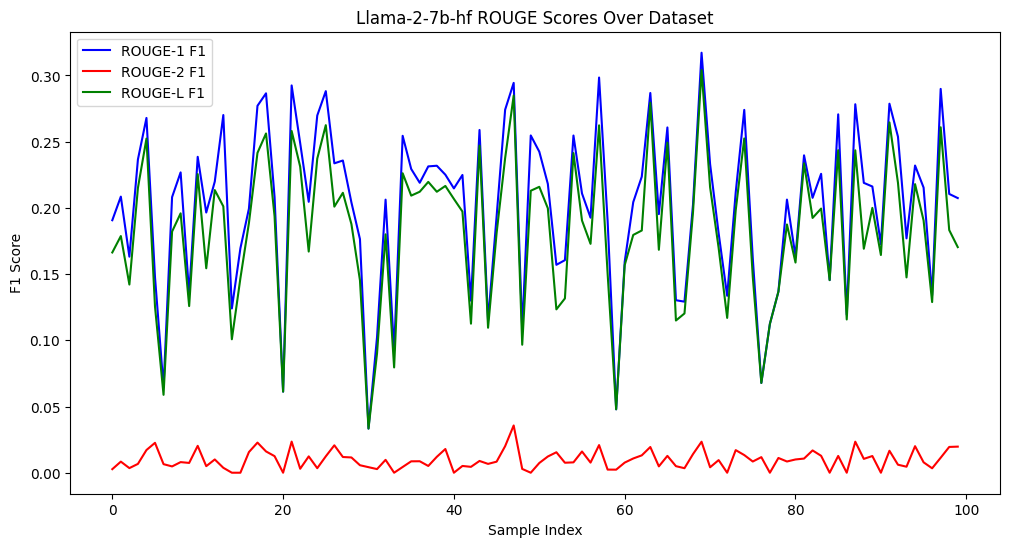

In [31]:
import matplotlib.pyplot as plt

# # Extract F1-scores for each ROUGE metric
# rouge_1_f1_baseline = [score[0]['rouge-1']['f'] for score in rouge_scores_baseline]
# rouge_2_f1_baseline = [score[0]['rouge-2']['f'] for score in rouge_scores_baseline]
# rouge_l_f1_baseline = [score[0]['rouge-l']['f'] for score in rouge_scores_baseline]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(rouge_1_f1_baseline, label='ROUGE-1 F1', color='blue')
# plt.plot(rouge_2_f1_baseline, label='ROUGE-2 F1', color='red')
# plt.plot(rouge_l_f1_baseline, label='ROUGE-L F1', color='green')

# plt.title('Baseline ROUGE Scores Over Dataset')
# plt.xlabel('Sample Index')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.savefig('rouge_score_baseline.png')
# plt.show()

rouge_1_f1_outputs = [score[0]['rouge-1']['f'] for score in rouge_scores_outputs]
rouge_2_f1_outputs = [score[0]['rouge-2']['f'] for score in rouge_scores_outputs]
rouge_l_f1_outputs = [score[0]['rouge-l']['f'] for score in rouge_scores_outputs]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rouge_1_f1_outputs, label='ROUGE-1 F1', color='blue')
plt.plot(rouge_2_f1_outputs, label='ROUGE-2 F1', color='red')
plt.plot(rouge_l_f1_outputs, label='ROUGE-L F1', color='green')

plt.title('Llama-2-7b-hf ROUGE Scores Over Dataset')
plt.xlabel('Sample Index')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('rouge_score_Llama-2-7b-hf.png')
plt.show()